In [5]:
import librosa
import numpy as np
from numpy import inf, argmin
import math
import wave
import pyaudio
from scipy.spatial.distance import pdist
import pylab as pl

In [6]:
# 读取wav，返回采样值y
def readWav(path):
    y, sr = librosa.load(path, sr=16000)
    return y

# 录制wav，时长s
def recordWav(name):
    # 参数定义
    CHUNK = 1024
    FORMAT = pyaudio.paInt16
    CHANNELS = 1  # 声道数
    RATE = 16000  # 采样率
    RECORD_SECONDS = 1.5  # 录制时长
    WAVE_OUTPUT_FILENAME = name

    p = pyaudio.PyAudio()
    stream = p.open(format=FORMAT, channels=CHANNELS, rate=RATE, input=True, frames_per_buffer=CHUNK)

    print('* recording')
    frames = []
    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print('* done recording')
    stream.stop_stream()
    stream.close()
    p.terminate()

    print('* save recording')
    wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()

In [7]:
def preProcess(wave_data, wave_len, framesize, overlap):
    # 步长
    step = framesize - overlap
    # 帧数
    frame_num = int(math.ceil(wave_len * 1.0 / step))
    # 归一化
    wave_tmp = wave_data.copy()
    wave_tmp = wave_tmp * 1.0 / max(abs(wave_tmp))
    # 计算音量
    volume = np.zeros((frame_num, 1))
    for i in range(frame_num):
        # 取段
        cur_frame = wave_tmp[np.arange(i * step, min(i * step + framesize, wave_len))]
        # zero-justified
        cur_frame = cur_frame - np.median(cur_frame)
        # volume = sigma(1,n)|x[i]|
        volume[i] = np.sum(np.abs(cur_frame))  # 10*np.log10(np.sum(cur_frame*cur_frame))#
    # 置零
    wave_old = wave_data.copy()
    avg = np.average(abs(volume))
    for i in range(frame_num):
        if volume[i] < 0.6 * avg:
            wave_data[np.arange(i * step, min(i * step + framesize, wave_len))] = 0
    '''
    # 切下有声部分
    p = 0
    q = wave_len - 1
    while (wave_data[p] == 0):
        p = p + 1
    while (wave_data[q] == 0):
        q = q - 1
    wave_new = wave_old[p:(q + 1)].copy()
    '''
    return wave_data

In [44]:
def getTemplate(path, lst, new_path):
    y = readWav(path+lst[0])
    X = librosa.feature.mfcc(y=y, sr=16000, n_mfcc=20)
    
    result = X.copy()
    count = np.ones(X.shape[1], dtype=int)
    
    for i in range(1, len(lst)):
        y = readWav(path+lst[i])
        Y = librosa.feature.mfcc(y=y, sr=16000, n_mfcc=20)
        D, wp = librosa.sequence.dtw(Y, X, step_sizes_sigma=np.array([[1, 0], [1, 1], [1, 2]]))
        for j in range(wp.shape[0]):
            result[:, wp[i][1]] = result[:, wp[i][1]] + Y[:, wp[i][0]]
            count[wp[i][1]] = count[wp[i][1]] + 1
    # 平均
    for i in range(result.shape[1]):
        result[:, i] = result[:, i] / count[i]
    # 保存
    np.savetxt(new_path, result, fmt='%.6f',delimiter = ',')
    
    return result

In [45]:
def recongnition(wave_data, template_path_lst):
    X = librosa.feature.mfcc(y=wave_data, sr=16000, n_mfcc=20)
    
    rst = []
    for item in template_path_lst:
        Y = np.loadtxt(item, delimiter=",")
        D, wp = librosa.sequence.dtw(X, Y, step_sizes_sigma=np.array([[1, 0], [1, 1], [1, 2]]))
        rst.append(D[wp[0][0], wp[0][1]])
    min_value = min(rst)
    
    return rst.index(min_value)

In [46]:
# template for 0, 1, ..., 9
path_lst = ['records\\go\\', 'records\\stop\\', 'records\\back\\', 'records\\left\\', 'records\\right\\']
lst = [['1_go.wav', '2_go.wav', '3_go.wav', '4_go.wav', '5_go.wav'],
       ['1_stop.wav', '2_stop.wav', '3_stop.wav', '4_stop.wav', '5_stop.wav'],
       ['1_back.wav', '2_back.wav', '3_back.wav', '4_back.wav', '5_back.wav'],
       ['1_left.wav', '2_left.wav', '3_left.wav', '4_left.wav', '5_left.wav'],
       ['1_right.wav', '1_right.wav', '1_right.wav', '1_right.wav', '1_right.wav']]
template_path_lst = ['go.csv', 'stop.csv', 'back.csv', 'left.csv', 'right.csv']

framesize = 100
overlap = int(framesize / 2)

for i in range(len(path_lst)):
    getTemplate(path_lst[i], lst[i], template_path_lst[i])

In [11]:
import serial
ser = serial.Serial('COM6', 9600)

In [12]:
#['前', '停', '后', '左', '右']
command = ['f', 's', 'b', 'l', 'r']

In [60]:
name = 'test.wav'
recordWav(name)
y = readWav(name)
rst = recongnition(y, template_path_lst)
print(command[rst])

#ser.write(command[rst].encode())

* recording
* done recording
* save recording
r


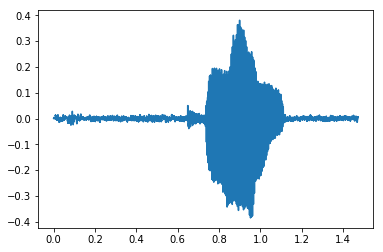

In [76]:
name = 'records\\stop\\2_stop.wav'
#recordWav(name)
y = readWav(name)
time = np.arange(0, y.shape[0]) * (1.0 / 16000)
pl.plot(time, y)
pl.show()

#new_y = preProcess(y, y.shape[0], 50, 25)
#time = np.arange(0, new_y.shape[0]) * (1.0 / 16000)
#pl.plot(time, new_y)
#pl.show()